In [30]:
import librosa
import librosa.display
from playsound import playsound

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Partie 1 : Manipulation de fichiers audio

### Partie 1.1

In [9]:
audio_file = 'audio/classique/Mozart-String-Quartet.mp3'
playsound(audio_file)


    Error 265 for command:
        open audio/classique/Mozart-String-Quartet.mp3
    Le nom de périphérique est déjà utilisé en tant qu’alias par cette application. Utilisez un alias unique.

    Error 263 for command:
        close audio/classique/Mozart-String-Quartet.mp3
    Le périphérique spécifié n’est pas ouvert ou n’est pas reconnu par MCI.
Failed to close the file: audio/classique/Mozart-String-Quartet.mp3


PlaysoundException: 
    Error 265 for command:
        open audio/classique/Mozart-String-Quartet.mp3
    Le nom de périphérique est déjà utilisé en tant qu’alias par cette application. Utilisez un alias unique.

### Partie 1.2

In [10]:
y, sr = librosa.load(audio_file)

print(f"Fréquence d'échantillonnage : {sr} Hz")
print(f"Nombre de valeurs dans l'audio : {len(y)}")

duration = len(y) / sr
print(f"Durée du morceau : {duration} secondes")

Fréquence d'échantillonnage : 22050 Hz
Nombre de valeurs dans l'audio : 5909845
Durée du morceau : 268.0201814058957 secondes


### Partie 1.3

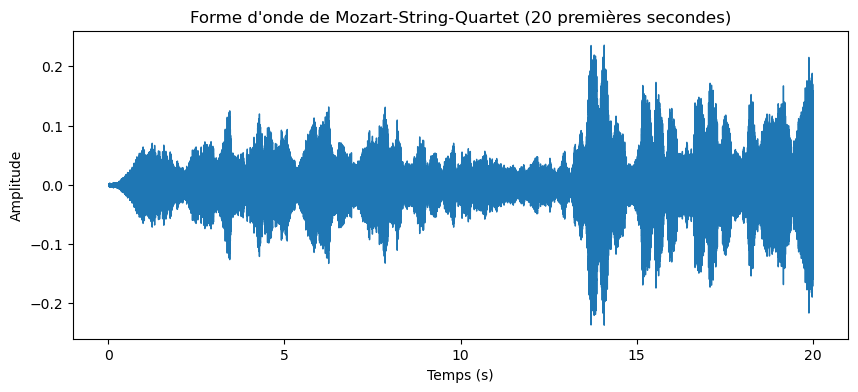

In [11]:
y_20s = y[:int(sr * 20)]

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_20s, sr=sr)
plt.title('Forme d\'onde de Mozart-String-Quartet (20 premières secondes)')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.show()

# Partie 2 : Représentation MFCCs

### Partie 2.1 + 2.2

In [12]:
y_10s = y[:int(sr * 10)]
mfccs = librosa.feature.mfcc(y=y_10s, sr=sr, n_mfcc=12)

print(f"Dimensions des coefficients MFCCs : {mfccs.shape}")

frame_length = librosa.frames_to_time(mfccs.shape[-1], sr=sr)
print(f"Nombre de valeurs calculées par seconde : {mfccs.shape[-1] / frame_length}")

Dimensions des coefficients MFCCs : (12, 431)
Nombre de valeurs calculées par seconde : 43.06640625


### Partie 2.3

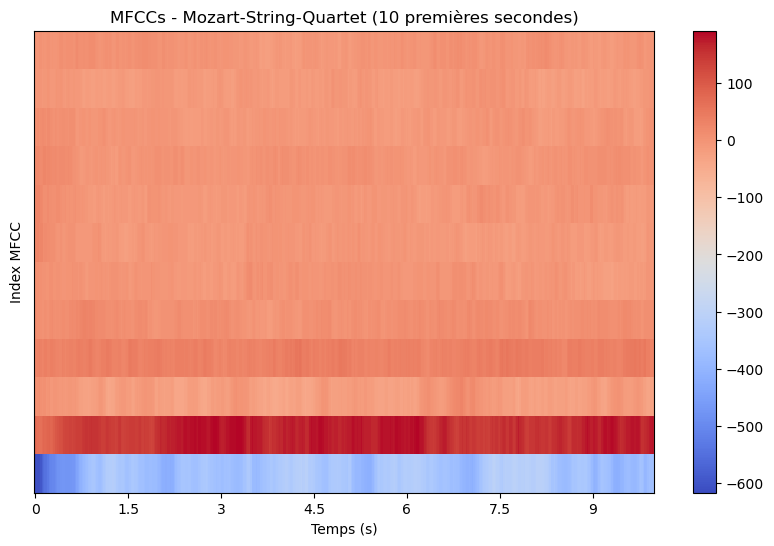

In [13]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.title('MFCCs - Mozart-String-Quartet (10 premières secondes)')
plt.colorbar()
plt.xlabel('Temps (s)')
plt.ylabel('Index MFCC')
plt.show()

# Partie 3 : Préparation des descripteurs

### Partie 3.1

La fonction librosa.feature.mfcc retourne une matrice de dimensions (n_mfcc, n_frames) :

* n_mfcc : nombre de coefficients MFCC calculés par frame (dans votre cas, 12).

* n_frames : nombre de fenêtres temporelles (trames), chaque fenêtre représentant une portion de l'audio.

Ainsi, la fonction mfcc renvoie une matrice où chaque colonne correspond à un descripteur temporel et chaque ligne correspond à un des 12 coefficients. Ce format est correct pour l'apprentissage, car chaque colonne (frame) représente une fenêtre temporelle de l'audio avec ses 12 descripteurs.

Si vous souhaitez avoir une séquence de descripteurs sous la forme d'un vecteur pour chaque fenêtre temporelle, alors la sortie de mfcc est déjà dans le format approprié.

### Partie 3.2

In [15]:
print(f"Forme des MFCCs avant normalisation : {mfccs.shape}")

scaler = StandardScaler()
mfccs_normalized = scaler.fit_transform(mfccs.T).T

print(f"Forme des MFCCs après normalisation : {mfccs_normalized.shape}")

Forme des MFCCs avant normalisation : (12, 431)
Forme des MFCCs après normalisation : (12, 431)


### Partie 3.3

Moyennes après normalisation : [ 3.5403222e-08  0.0000000e+00  0.0000000e+00 -1.3276209e-08
  0.0000000e+00 -8.8508054e-09  0.0000000e+00  8.8508054e-09
  1.3276209e-08  0.0000000e+00  8.8508054e-09  8.8508054e-09]
Écarts-types après normalisation : [1.         1.         1.         0.99999994 1.         1.
 1.         1.         1.         1.         0.99999994 1.        ]


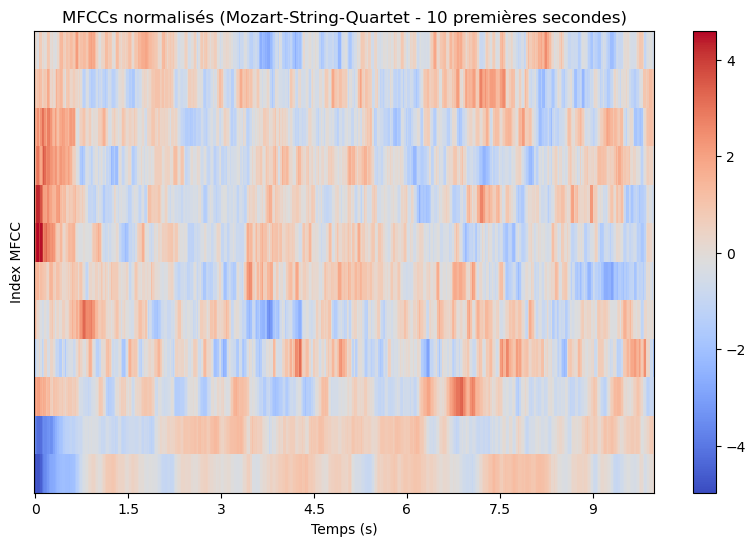

In [16]:
means = np.mean(mfccs_normalized, axis=1)
std_devs = np.std(mfccs_normalized, axis=1)

print("Moyennes après normalisation :", means)
print("Écarts-types après normalisation :", std_devs)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs_normalized, x_axis='time', sr=sr)
plt.title('MFCCs normalisés (Mozart-String-Quartet - 10 premières secondes)')
plt.colorbar()
plt.xlabel('Temps (s)')
plt.ylabel('Index MFCC')
plt.show()

# Partie 4 : Entraînement d'un modèle

### Partie 4.1

In [18]:
def extract_mfcc(audio_file, duration=20, sr=None):
    y, sr = librosa.load(audio_file, sr=sr, duration=duration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    return mfccs.T

In [19]:
mozart_file = 'audio/classique/Mozart-String-Quartet.mp3'
rodrigo_file = 'audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3'

mozart_mfcc = extract_mfcc(mozart_file)
rodrigo_mfcc = extract_mfcc(rodrigo_file)

### Partie 4.2

In [20]:
mozart_labels = np.zeros(mozart_mfcc.shape[0])
rodrigo_labels = np.ones(rodrigo_mfcc.shape[0])

X = np.vstack((mozart_mfcc, rodrigo_mfcc))
y = np.hstack((mozart_labels, rodrigo_labels))

### Partie 4.3

In [21]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy * 100:.2f}%")

Précision du modèle : 100.00%


# Partie 5 : Evaluation du modèle

### Partie 5.1

In [23]:
def extract_mfcc_validation(audio_file, start_sec=20, duration=5, sr=None):
    y, sr = librosa.load(audio_file, sr=sr, offset=start_sec, duration=duration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    return mfccs.T

In [25]:
mozart_mfcc_validation = extract_mfcc_validation(mozart_file, start_sec=20)
rodrigo_mfcc_validation = extract_mfcc_validation(rodrigo_file, start_sec=20)

mozart_labels_validation = np.zeros(mozart_mfcc_validation.shape[0])
rodrigo_labels_validation = np.ones(rodrigo_mfcc_validation.shape[0])

X_validation = np.vstack((mozart_mfcc_validation, rodrigo_mfcc_validation))
y_validation = np.hstack((mozart_labels_validation, rodrigo_labels_validation))

X_validation_normalized = scaler.transform(X_validation)

### Partie 5.2

In [26]:
y_pred_validation = svm_model.predict(X_validation_normalized)

### Partie 5.3

In [27]:
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Précision sur l'ensemble de validation : {accuracy_validation * 100:.2f}%")

Précision sur l'ensemble de validation : 100.00%


### Partie 5.4

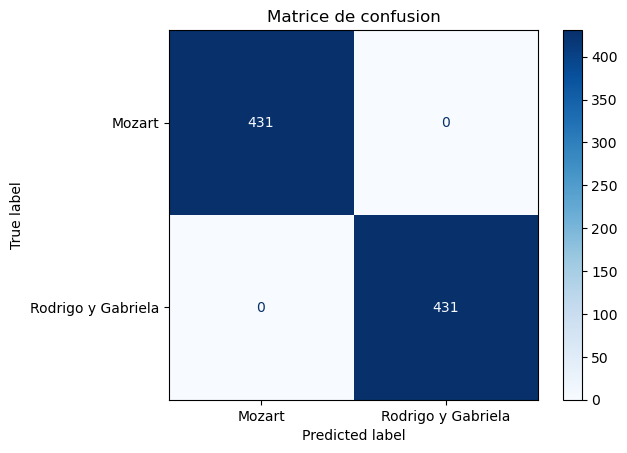

In [29]:
cm = confusion_matrix(y_validation, y_pred_validation, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mozart", "Rodrigo y Gabriela"])
disp.plot(cmap='Blues')

plt.title('Matrice de confusion')
plt.show()

# Partie 6 : Expériences

### Partie 6.1

In [ ]:
# Expérience : Variation du nombre de coefficients MFCCs
def experiment_mfcc_coefficients(audio_file, n_mfcc_values):
    scores = []
    
    for n_mfcc in n_mfcc_values:
        X_train_mfcc = librosa.feature.mfcc(y=y_train, sr=sr_train, n_mfcc=n_mfcc)
        X_test_mfcc = librosa.feature.mfcc(y=y_test, sr=sr_test, n_mfcc=n_mfcc)

        X_train_normalized = scaler.fit_transform(X_train_mfcc.T)
        X_test_normalized = scaler.transform(X_test_mfcc.T)

        svm_model.fit(X_train_normalized, y_train)

        y_pred = svm_model.predict(X_test_normalized)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    plt.plot(n_mfcc_values, scores, marker='o')
    plt.xlabel('Nombre de coefficients MFCC')
    plt.ylabel('Précision')
    plt.title('Évolution de la précision en fonction du nombre de coefficients MFCC')
    plt.show()

n_mfcc_values = [12, 13, 20, 25]
experiment_mfcc_coefficients(mozart_file, n_mfcc_values)

### Partie 6.2

In [ ]:
def experiment_window_size(audio_file, window_sizes):
    scores = []
    
    for win_size in window_sizes:
        mfccs = librosa.feature.mfcc(y=y_train, sr=sr_train, n_mfcc=12, n_fft=win_size)

        X_train_normalized = scaler.fit_transform(mfccs.T)

        svm_model.fit(X_train_normalized, y_train)

        y_pred = svm_model.predict(X_test_normalized)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    plt.plot(window_sizes, scores, marker='o')
    plt.xlabel('Taille de la fenêtre (n_fft)')
    plt.ylabel('Précision')
    plt.title('Évolution de la précision en fonction de la taille de la fenêtre (n_fft)')
    plt.show()

window_sizes = [1024, 2048, 4096]
experiment_window_size(mozart_file, window_sizes)

### Partie 6.3

In [ ]:
def experiment_training_set_size(audio_file, training_sizes):
    scores = []
    
    for train_size in training_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, train_size=train_size, random_state=42)

        svm_model.fit(X_train, y_train)

        y_pred = svm_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    plt.plot(training_sizes, scores, marker='o')
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('Précision')
    plt.title('Évolution de la précision en fonction de la taille de l\'ensemble d\'entraînement')
    plt.show()

training_sizes = [0.1, 0.2, 0.5, 0.8]
experiment_training_set_size(mozart_file, training_sizes)

### Partie 6.5

In [ ]:
def experiment_stylistic_classification():
    audio_files_train = ['audio/classique/Mozart-String-Quartet.mp3', 'audio/flamenco/Rodrigo-y-Gabriela-Hanuman.mp3']
    audio_files_val = ['audio/classique/Haydn-String-Quartet.mp3', 'audio/flamenco/Paco-De-Lucia-Rio-Ancho.mp3']

    X_train = np.vstack([extract_mfcc(file) for file in audio_files_train])
    y_train = np.hstack([np.zeros(len(X_train[0])), np.ones(len(X_train[1]))])
    
    X_val = np.vstack([extract_mfcc(file) for file in audio_files_val])
    y_val = np.hstack([np.zeros(len(X_val[0])), np.ones(len(X_val[1]))])

    X_train

### Partie 6.6

In [ ]:
def experiment_classifiers(X_train, y_train, X_test, y_test):
    classifiers = {
        "SVM": SVC(kernel='linear'),
        "KNN": KNeighborsClassifier(),
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier()
    }
    
    scores = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        scores[name] = accuracy

    plt.bar(scores.keys(), scores.values())
    plt.xlabel('Classificateur')
    plt.ylabel('Précision')
    plt.title('Comparaison des classificateurs')
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
experiment_classifiers(X_train, y_train, X_test, y_test)